<a href="https://colab.research.google.com/github/jgbrenner/psychometrics/blob/main/GenAI_BTPS_PsychometricsC9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive and set paths
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import openai
import pandas as pd
import numpy as np
import json
import requests
import re
from google.colab import drive, userdata

In [3]:
# Define the path where the R library will be saved in Google Drive
library_path = '/content/drive/MyDrive/R_libraries'

# Create the directory if it doesn't exist
if not os.path.exists(library_path):
    os.makedirs(library_path)

In [4]:
# Load rpy2 for R integration
%load_ext rpy2.ipython

In [5]:
# Set R library path
from rpy2.robjects import r
r(f'.libPaths(c("{library_path}", .libPaths()))')

'/content/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


In [6]:
# Fetching the OpenAI API key from Colab secrets
openai_api_key = userdata.get('OPENAI_API_KEY')
if openai_api_key:
    os.environ["OPENAI_API_KEY"] = openai_api_key
else:
    raise ValueError("OPENAI_API_KEY is not set or invalid.")

# Import OpenAI Client
from openai import Client
client = Client()

Prompt the LLM

In [7]:


# Define the LLM prompt
messages = [
    {
        "role": "system",
        "content": "You are an expert psychometrician specializing in creating test items for psychological scales."
    },
    {
        "role": "user",
        "content": """
### Instructions:
You are tasked with generating items for three types of perfectionism based on the Big Three Perfectionism Scale (BTPS):
1. Rigid Perfectionism (RP)
2. Self-Critical Perfectionism (SCP)
3. Narcissistic Perfectionism (NP)

### Definitions and Examples:
Each type is defined below, with example items to guide you. Follow the EXACT format of these examples and generate 20 new items for each type. Be creative but ensure the items align with the definitions.

#### Rigid Perfectionism (RP)
Definition: Setting excessively high personal standards and adhering to them rigidly, often linked to fear of failure or criticism.
Example Items:
- "Rigid Perfectionism: I have a strong need to be perfect."
- "Rigid Perfectionism: Striving to be as perfect as possible makes me feel worthwhile."

#### Self-Critical Perfectionism (SCP)
Definition: Harshly criticizing oneself for perceived failures, accompanied by feelings of worthlessness or self-doubt.
Example Items:
- "Self-Critical Perfectionism: The idea of making a mistake frightens me."
- "Self-Critical Perfectionism: I feel disappointed with myself, when I don’t do something perfectly"

#### Narcissistic Perfectionism (NP)
Definition: Projecting an image of perfection to others, demanding admiration, and being critical of others’ imperfections.
Example Items:
- "Narcissistic Perfectionism: I expect those close to me to be perfect."
- "Narcissistic Perfectionism: It bothers me when people don’t notice how perfect I am."

### Desired Output Format:
Each item should be written on a single line, with the construct and item separated by a colon. For example:
Rigid Perfectionism: I often feel that anything less than perfect is unacceptable.

### Output:
Generate 20 items per type, formatted EXACTLY as shown in the desired output format.
"""
    }
]

# Call the OpenAI API

try:
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.7,
        max_tokens=8500,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )


    # Parse the response 0 here
    response_content = completion.choices[0].message.content.strip()
    print("Generated Items:\n", response_content)

    # Save the output to a CSV
    items = response_content.split("\n")
    items_df = pd.DataFrame(items, columns=["item"])
    items_df.to_csv("generated_items.csv", index=False)
    print("Items saved to 'generated_items.csv'.")
except Exception as e:
    print(f"An error occurred: {e}")


Generated Items:
 #### Rigid Perfectionism (RP)
1. Rigid Perfectionism: I often feel that I must meet my own high standards at all costs.
2. Rigid Perfectionism: I find it difficult to relax unless everything is done perfectly.
3. Rigid Perfectionism: I am very hard on myself if I make any mistakes.
4. Rigid Perfectionism: I believe that achieving perfection is the only way to succeed.
5. Rigid Perfectionism: I often feel anxious if I think I might not meet my goals.
6. Rigid Perfectionism: I tend to fixate on the details to ensure everything is flawless.
7. Rigid Perfectionism: I feel a sense of failure if I do not meet my self-imposed standards.
8. Rigid Perfectionism: I believe that being perfect is essential to my self-worth.
9. Rigid Perfectionism: I often set impossible goals for myself that I must achieve.
10. Rigid Perfectionism: I feel stressed when I think about the possibility of not being perfect.
11. Rigid Perfectionism: I push myself to work harder when I make a mistake.


In [9]:
# Split into lines and strip whitespace
items = [line.strip() for line in response_content.strip().split("\n") if line.strip()]

# Split each line into "construct" and "item" using the colon
processed_items = [line.split(": ", 1) for line in items]

# Create a DataFrame
items_df = pd.DataFrame(processed_items, columns=["construct", "item"])

# Save to CSV
items_df.to_csv("cleaned_generated_items.csv", index=False)
print("Cleaned items saved to 'cleaned_generated_items.csv'.")

Cleaned items saved to 'cleaned_generated_items.csv'.


In [10]:
# Save the "item" column to a new CSV
items_df[["item"]].to_csv("test_items.csv", index=False)
print("Test items saved to 'test_items.csv'.")


Test items saved to 'test_items.csv'.


In [11]:
import pandas as pd
import numpy as np
import json
import requests

# Read the items back
test_items_df = pd.read_csv("test_items.csv")

# Clean and validate the items column
test_items_df['item'] = test_items_df['item'].str.strip()  # Remove leading/trailing spaces
test_items_df = test_items_df.dropna(subset=['item'])  # Drop rows with NaN in 'item'
test_items_df = test_items_df[test_items_df['item'] != ""]  # Drop empty strings
test_items_df = test_items_df[test_items_df['item'].apply(lambda x: isinstance(x, str))]  # Keep only strings

# Ensure the cleaned data is valid
if test_items_df.empty:
    raise ValueError("No valid items found in the test_items.csv after cleaning.")

# Prepare the list of items
items = test_items_df['item'].tolist()

# Print a preview of cleaned items
print("Cleaned Items for Embeddings:")
print(items[:5])  # Preview first 5 items

# Assuming you have the OpenAI API integration
embedding_endpoint = "https://api.openai.com/v1/embeddings"
embedding_model = "text-embedding-3-small"

headers = {
    "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    "Content-Type": "application/json"
}

# Split into chunks to ensure input fits within the API limit
data = {
    "model": embedding_model,
    "input": items
}

response = requests.post(embedding_endpoint, headers=headers, json=data)

if response.status_code == 200:
    # Extract embeddings
    embeddings = [result["embedding"] for result in response.json()["data"]]

    # Save embeddings as CSV
    embeddings_df = pd.DataFrame(embeddings)
    embeddings_df.to_csv("embeddings.csv", index=False, header=False)
    print(f"Embeddings generated and saved as CSV. Shape: {embeddings_df.shape}")
else:
    print(f"Embedding request failed: {response.text}")


Cleaned Items for Embeddings:
['I feel intense pressure to meet my own high expectations.', 'I often become anxious if I think I might not achieve perfection.', 'I believe that making mistakes is completely unacceptable.', 'I hold myself to standards that are difficult to achieve.', 'I frequently set goals that are unreachable.']
Embeddings generated and saved as CSV. Shape: (60, 1536)


start here

In [7]:
%%R

# Load required libraries and set library path
library_path <- '/content/drive/MyDrive/R_libraries'
.libPaths(library_path)

library(EGAnet, lib.loc = library_path)
library(dplyr, lib.loc = library_path)


EGAnet (version 2.1.0) 

For help getting started, see <https://r-ega.net> 

For bugs and errors, submit an issue to <https://github.com/hfgolino/EGAnet/issues>

Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union




In [8]:
%%R

# Load test items and embeddings
test_items <- read.csv("test_items.csv", stringsAsFactors = FALSE)
embeddings <- as.matrix(read.csv("embeddings.csv", header = FALSE))

# Verify dimensions
cat("Dimensions of Test Items:\n")
print(dim(test_items))
cat("Dimensions of Embeddings:\n")
print(dim(embeddings))




Dimensions of Test Items:
[1] 60  1
Dimensions of Embeddings:
[1]   60 1536


In [9]:
%%R

# Compute correlation matrix
cor_matrix <- cor(t(embeddings))
cor_matrix[is.na(cor_matrix)] <- 0  # Replace NAs with 0

# Check dimensions and preview
cat("Correlation Matrix Dimensions:\n")
print(dim(cor_matrix))
cat("Correlation Matrix Sample:\n")
print(cor_matrix[1:5, 1:5])


Correlation Matrix Dimensions:
[1] 60 60
Correlation Matrix Sample:
          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 1.0000000 0.5505627 0.2872420 0.6279186 0.4247307
[2,] 0.5505627 1.0000000 0.3184419 0.5117448 0.4795368
[3,] 0.2872420 0.3184419 1.0000000 0.3335414 0.2949943
[4,] 0.6279186 0.5117448 0.3335414 1.0000000 0.5642920
[5,] 0.4247307 0.4795368 0.2949943 0.5642920 1.0000000


Summary Statistics for Correlation Matrix:
Summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1621  0.3532  0.4233  0.4282  0.4977  0.8027 

Mean Correlation:
[1] 0.4282386

Standard Deviation of Correlations:
[1] 0.1043722

Range of Correlations:
[1] 0.1621491 0.8026980


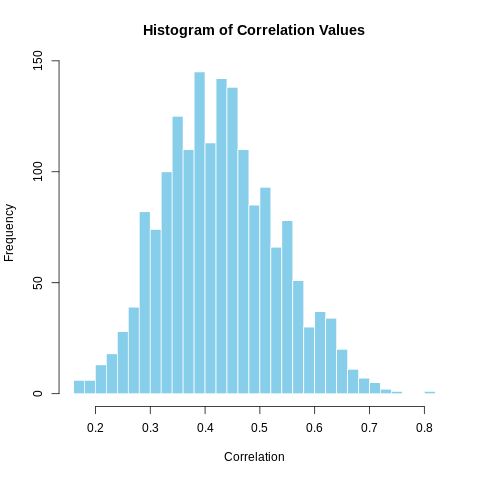

In [10]:
%%R

# Summary Statistics for the Correlation Matrix
cat("Summary Statistics for Correlation Matrix:\n")

# Convert the correlation matrix to a vector (excluding diagonal values)
cor_values <- cor_matrix[lower.tri(cor_matrix)]

# Summary statistics
summary_stats <- summary(cor_values)
cat("Summary:\n")
print(summary_stats)

# Additional statistics
cat("\nMean Correlation:\n")
mean_cor <- mean(cor_values)
print(mean_cor)

cat("\nStandard Deviation of Correlations:\n")
sd_cor <- sd(cor_values)
print(sd_cor)

cat("\nRange of Correlations:\n")
range_cor <- range(cor_values)
print(range_cor)

# Histogram of correlation values
hist(
  cor_values,
  breaks = 30,
  col = "skyblue",
  main = "Histogram of Correlation Values",
  xlab = "Correlation",
  border = "white"
)


In [11]:
%%R

evaluate_sparsity <- function(cor_matrix, thresholds) {
    sparsity_results <- data.frame(Threshold = numeric(), Zeroed_Out = numeric())

    for (threshold in thresholds) {
        thresholded_matrix <- cor_matrix
        thresholded_matrix[abs(thresholded_matrix) < threshold] <- 0

        zeroed_out <- sum(thresholded_matrix == 0) / (nrow(cor_matrix) * ncol(cor_matrix))
        sparsity_results <- rbind(sparsity_results, data.frame(Threshold = threshold, Zeroed_Out = zeroed_out))
    }

    cat("Sparsity Results:\n")
    print(sparsity_results)
}

# Evaluate for chosen thresholds
evaluate_sparsity(cor_matrix, thresholds = c(0.2, 0.25, 0.3, 0.35, 0.4))


Sparsity Results:
  Threshold  Zeroed_Out
1      0.20 0.006666667
2      0.25 0.028888889
3      0.30 0.106666667
4      0.35 0.237222222
5      0.40 0.414444444


In [16]:
%%R

library(FactoMineR)

# Perform PCA
pca_result <- PCA(as.data.frame(cor_matrix), graph = FALSE)

# Plot explained variance
barplot(pca_result$eig[, 2], main = "Explained Variance by Principal Components", xlab = "Principal Component", ylab = "Explained Variance (%)")



Error in library(FactoMineR) : there is no package called ‘FactoMineR’


Attaching package: ‘igraph’



    as_data_frame, groups, union



    modularity



    decompose, spectrum



    union




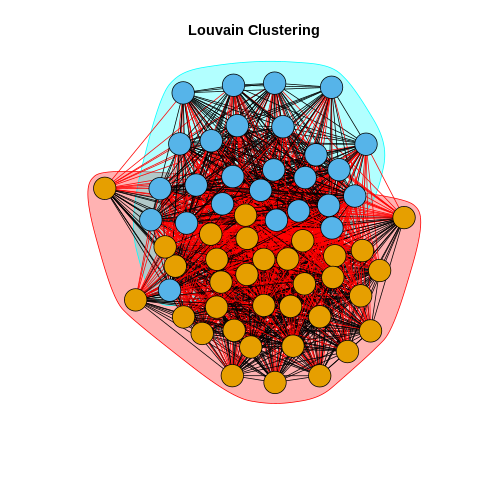

In [12]:
%%R

library(igraph)

# Define a threshold
threshold <- 0.3  # Adjust this value based on your experiment

# Threshold the correlation matrix
thresholded_matrix <- cor_matrix
thresholded_matrix[abs(thresholded_matrix) < threshold] <- 0

# Ensure the matrix is symmetric and valid
diag(thresholded_matrix) <- 0  # Set diagonal elements to 0 for adjacency matrix

# Convert to igraph object
network <- graph_from_adjacency_matrix(thresholded_matrix, mode = "undirected", weighted = TRUE)

# Apply Louvain clustering
louvain_result <- cluster_louvain(network)

# Plot clusters
plot(louvain_result, network, vertex.label = NA, main = "Louvain Clustering")


In [13]:
%%R


cat("--- Sparsity of Thresholded Correlation Matrix ---\n")
cat("Proportion of Zeroed-Out Correlations:\n")
print(mean(thresholded_matrix == 0))


--- Sparsity of Thresholded Correlation Matrix ---
Proportion of Zeroed-Out Correlations:
[1] 0.1233333


 [1] 1 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 1 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 2 1 3 2 1
[39] 2 2 1 2 1 3 1 1 1 1 2 1 2 1 3 1 2 1 3 1 1 1


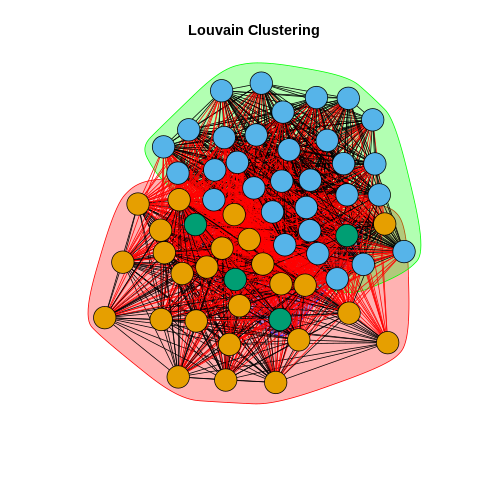

In [14]:
%%R

louvain_result <- cluster_louvain(network)
plot(louvain_result, network, vertex.label = NA, main = "Louvain Clustering")
print(membership(louvain_result))  # Community assignments


 [1] 2 1 2 2 1 1 1 1 1 2 2 1 1 1 2 1 1 2 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 2 2 1 2
[39] 1 1 2 1 2 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 2 2


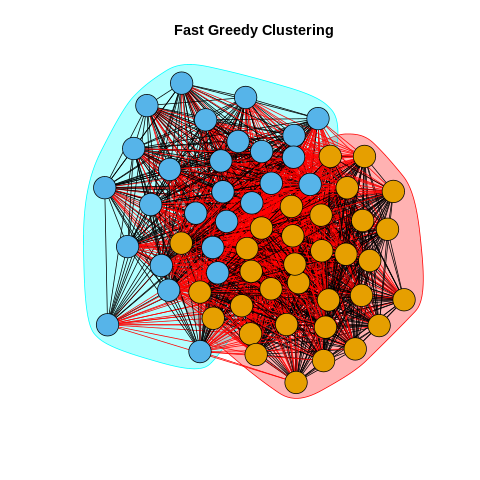

In [15]:
%%R

fast_greedy_result <- cluster_fast_greedy(network)
plot(fast_greedy_result, network, vertex.label = NA, main = "Fast Greedy Clustering")
print(membership(fast_greedy_result))


 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


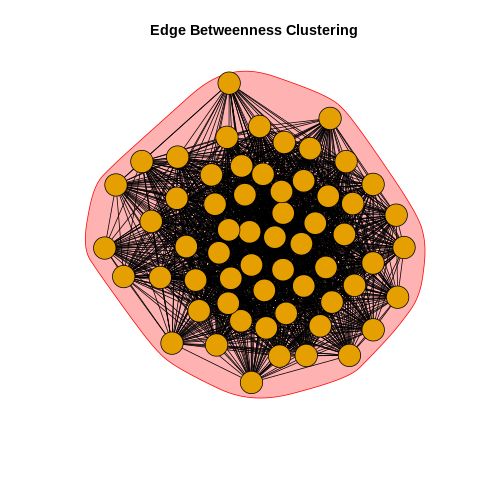

In [16]:
%%R

edge_betweenness_result <- cluster_edge_betweenness(network)
plot(edge_betweenness_result, network, vertex.label = NA, main = "Edge Betweenness Clustering")
print(membership(edge_betweenness_result))


 [1] 1 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 1 1 2 1
[39] 2 2 1 1 1 2 1 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1


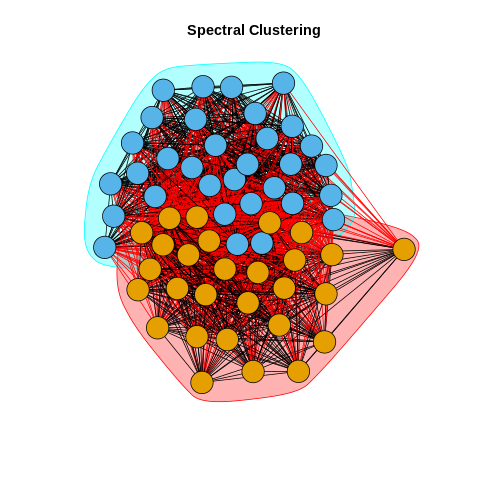

In [17]:
%%R

spectral_result <- cluster_leading_eigen(network)
plot(spectral_result, network, vertex.label = NA, main = "Spectral Clustering")
print(membership(spectral_result))


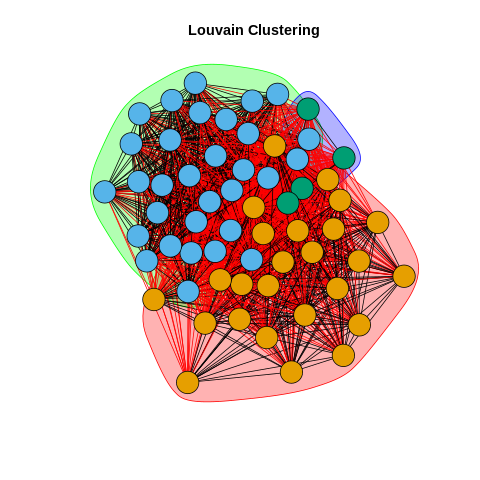

In [20]:
%%R

library(igraph)

# Convert to igraph object
network <- graph_from_adjacency_matrix(thresholded_matrix, mode = "undirected", weighted = TRUE)

# Apply Louvain clustering
louvain_result <- cluster_louvain(network)

# Plot clusters
plot(louvain_result, network, vertex.label = NA, main = "Louvain Clustering")


In [20]:
%%R

# Load required libraries
library(igraph)

# Create the network graph from the thresholded matrix
network <- graph_from_adjacency_matrix(thresholded_matrix, mode = "undirected", weighted = TRUE)

# Function to compute clustering metrics
compute_clustering_metrics <- function(cluster_result, algorithm_name) {
    # Community memberships
    community_membership <- membership(cluster_result)

    # Number of communities
    num_communities <- length(unique(community_membership))

    # Modularity score
    modularity_score <- modularity(cluster_result)

    # Node distribution per community
    node_distribution <- table(community_membership)

    # Print stats
    cat("\n---", algorithm_name, "---\n")
    cat("Number of Communities:", num_communities, "\n")
    cat("Modularity Score:", modularity_score, "\n")
    cat("Node Distribution:\n")
    print(node_distribution)

    # Return as a list
    return(list(
        algorithm = algorithm_name,
        num_communities = num_communities,
        modularity_score = modularity_score,
        node_distribution = node_distribution
    ))
}

# Louvain Clustering
louvain_result <- cluster_louvain(network)
louvain_metrics <- compute_clustering_metrics(louvain_result, "Louvain Clustering")

# Fast Greedy Clustering
fast_greedy_result <- cluster_fast_greedy(network)
fast_greedy_metrics <- compute_clustering_metrics(fast_greedy_result, "Fast Greedy Clustering")

# Edge Betweenness Clustering
edge_betweenness_result <- cluster_edge_betweenness(network)
edge_betweenness_metrics <- compute_clustering_metrics(edge_betweenness_result, "Edge Betweenness Clustering")

# Label Propagation Clustering
label_propagation_result <- cluster_label_prop(network)
label_propagation_metrics <- compute_clustering_metrics(label_propagation_result, "Label Propagation Clustering")

# Spectral Clustering
spectral_result <- cluster_leading_eigen(network)
spectral_metrics <- compute_clustering_metrics(spectral_result, "Spectral Clustering")

# Combine all results into a data frame
clustering_summary <- data.frame(
    Algorithm = c(
        louvain_metrics$algorithm,
        fast_greedy_metrics$algorithm,
        edge_betweenness_metrics$algorithm,
        label_propagation_metrics$algorithm,
        spectral_metrics$algorithm
    ),
    Num_Communities = c(
        louvain_metrics$num_communities,
        fast_greedy_metrics$num_communities,
        edge_betweenness_metrics$num_communities,
        label_propagation_metrics$num_communities,
        spectral_metrics$num_communities
    ),
    Modularity = c(
        louvain_metrics$modularity_score,
        fast_greedy_metrics$modularity_score,
        edge_betweenness_metrics$modularity_score,
        label_propagation_metrics$modularity_score,
        spectral_metrics$modularity_score
    )
)

# Print the summary
cat("\n--- Clustering Summary ---\n")
print(clustering_summary)



--- Louvain Clustering ---
Number of Communities: 3 
Modularity Score: 0.05065843 
Node Distribution:
community_membership
 1  2  3 
20 29 11 

--- Fast Greedy Clustering ---
Number of Communities: 2 
Modularity Score: 0.05144413 
Node Distribution:
community_membership
 1  2 
33 27 

--- Edge Betweenness Clustering ---
Number of Communities: 1 
Modularity Score: 2.220446e-16 
Node Distribution:
community_membership
 1 
60 

--- Label Propagation Clustering ---
Number of Communities: 1 
Modularity Score: 2.220446e-16 
Node Distribution:
community_membership
 1 
60 

--- Spectral Clustering ---
Number of Communities: 2 
Modularity Score: 0.04945484 
Node Distribution:
community_membership
 1  2 
28 32 

--- Clustering Summary ---
                     Algorithm Num_Communities   Modularity
1           Louvain Clustering               3 5.065843e-02
2       Fast Greedy Clustering               2 5.144413e-02
3  Edge Betweenness Clustering               1 2.220446e-16
4 Label Propagation 

In [22]:
%%R

# Reload the full cleaned dataset with constructs
full_items <- read.csv("cleaned_generated_items.csv", stringsAsFactors = FALSE)

# Ensure the test items dataset includes the construct column
test_items <- full_items %>%
  select(item, construct)  # Retain only 'item' and 'construct'

# Check the structure of the dataset
cat("Structure of Test Items Dataset:\n")
print(head(test_items))


Structure of Test Items Dataset:
                                                               item
1                                                                  
2         I feel intense pressure to meet my own high expectations.
3 I often become anxious if I think I might not achieve perfection.
4        I believe that making mistakes is completely unacceptable.
5         I hold myself to standards that are difficult to achieve.
6                      I frequently set goals that are unreachable.
                      construct
1 #### Rigid Perfectionism (RP)
2        1. Rigid Perfectionism
3        2. Rigid Perfectionism
4        3. Rigid Perfectionism
5        4. Rigid Perfectionism
6        5. Rigid Perfectionism


In [24]:
%%R

# Reload the dataset
full_items <- read.csv("cleaned_generated_items.csv", stringsAsFactors = FALSE)

# Inspect the dataset structure
cat("Initial Structure of Dataset:\n")
print(head(full_items))

# Keep only rows with non-empty 'item' values
cleaned_items <- full_items %>%
  filter(
    item != "" &  # Remove rows where 'item' is empty
    !is.na(item)  # Remove rows where 'item' is NA
  )

# Check the structure after cleaning
cat("\nStructure After Cleaning:\n")
print(head(cleaned_items))

# Save the cleaned dataset back to CSV
write.csv(cleaned_items, "cleaned_generated_items.csv", row.names = FALSE)
cat("\nCleaned dataset saved as 'cleaned_generated_items.csv'.\n")


Initial Structure of Dataset:
                      construct
1 #### Rigid Perfectionism (RP)
2        1. Rigid Perfectionism
3        2. Rigid Perfectionism
4        3. Rigid Perfectionism
5        4. Rigid Perfectionism
6        5. Rigid Perfectionism
                                                               item
1                                                                  
2         I feel intense pressure to meet my own high expectations.
3 I often become anxious if I think I might not achieve perfection.
4        I believe that making mistakes is completely unacceptable.
5         I hold myself to standards that are difficult to achieve.
6                      I frequently set goals that are unreachable.

Structure After Cleaning:
               construct
1 1. Rigid Perfectionism
2 2. Rigid Perfectionism
3 3. Rigid Perfectionism
4 4. Rigid Perfectionism
5 5. Rigid Perfectionism
6 6. Rigid Perfectionism
                                                               item


--- Louvain Clustering Summary ---
Number of Communities: 3 
Community Membership Distribution:
louvain_communities
 1  2  3 
25 31  4 

--- Clustered Items Summary ---
# A tibble: 3 × 4
  louvain_cluster items                                         constructs count
  <membrshp>      <chr>                                         <chr>      <int>
1 1               I feel intense pressure to meet my own high … 1. Rigid …    25
2 2               I often become anxious if I think I might no… 2. Rigid …    31
3 3               I feel inadequate when I see others succeed … 16. Self-…     4
png 
  2 


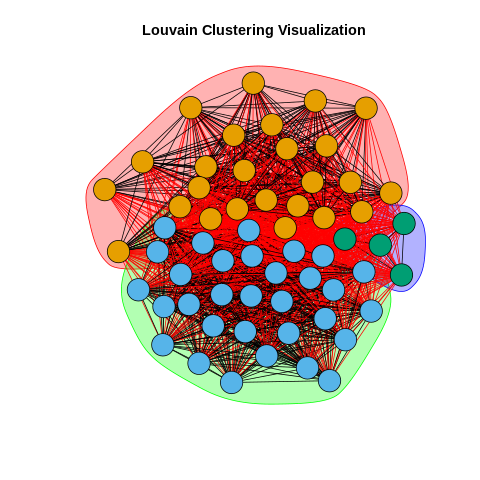

In [28]:
%%R

# Load the cleaned dataset
cleaned_items <- read.csv("cleaned_generated_items.csv", stringsAsFactors = FALSE)

# Ensure proper structure of the dataset
if (!all(c("item", "construct") %in% colnames(cleaned_items))) {
    stop("Dataset must have 'item' and 'construct' columns.")
}

# Perform Louvain clustering
louvain_result <- cluster_louvain(network)

# Extract community memberships
louvain_communities <- membership(louvain_result)

# Ensure row alignment between the dataset and communities
if (length(louvain_communities) != nrow(cleaned_items)) {
    stop("Mismatch between the number of items and Louvain community assignments.")
}

# Add Louvain cluster labels to the cleaned dataset
cleaned_items$louvain_cluster <- louvain_communities

# Summarize clusters
cat("--- Louvain Clustering Summary ---\n")
cat("Number of Communities:", length(unique(louvain_communities)), "\n")
cat("Community Membership Distribution:\n")
print(table(louvain_communities))

# Map items back to constructs and summarize clusters
clustered_items <- cleaned_items %>%
  group_by(louvain_cluster) %>%
  summarize(
    items = paste(item, collapse = "; "),
    constructs = paste(unique(construct), collapse = "; "),
    count = n(),
    .groups = "drop"  # Avoid warnings about grouped data
  )

# Print clustered items summary
cat("\n--- Clustered Items Summary ---\n")
print(clustered_items)

# Save results to CSV
write.csv(cleaned_items, "louvain_clustered_items.csv", row.names = FALSE)

# Visualize clusters
plot(
  louvain_result,
  network,
  vertex.label = NA,
  vertex.color = as.factor(louvain_communities),
  main = "Louvain Clustering Visualization"
)

# Save visualization as PDF
pdf("louvain_clustering_visualization.pdf")
plot(
  louvain_result,
  network,
  vertex.label = NA,
  vertex.color = as.factor(louvain_communities),
  main = "Louvain Clustering Visualization"
)
dev.off()


In [35]:
%%R


# Ensure Louvain clustering results are available
library(igraph)

# Create a network from the correlation matrix (thresholded or original)
network <- graph_from_adjacency_matrix(cor_matrix, mode = "undirected", weighted = TRUE)

# Perform Louvain clustering
louvain_result <- cluster_louvain(network)

# Add community labels to the dataset
louvain_communities <- membership(louvain_result)
test_items$louvain_cluster <- louvain_communities

# Summarize Louvain clustering results numerically
cluster_summary <- test_items %>%
  group_by(louvain_cluster) %>%
  summarize(
    item_count = n(),  # Count of items in each cluster
    constructs = paste(unique(construct), collapse = "; "),  # Unique constructs in each cluster
    example_items = paste(item[1:min(3, n())], collapse = "; ")  # First 3 example items
  )

# Print numerical summary
cat("--- Louvain Clustering Numerical Summary ---\n")
print(cluster_summary)

# Save the numerical summary to a CSV
write.csv(cluster_summary, "louvain_cluster_summary.csv", row.names = FALSE)

# Detailed item-cluster association
detailed_items <- test_items %>%
  select(item, construct, louvain_cluster)

# Print detailed association (first 10 rows for preview)
cat("\n--- Detailed Item-Cluster Association (Preview) ---\n")
print(head(detailed_items, 10))

# Save detailed item-cluster association to a CSV
write.csv(detailed_items, "louvain_clustered_detailed.csv", row.names = FALSE)


--- Louvain Clustering Numerical Summary ---
# A tibble: 7 × 4
  louvain_cluster item_count constructs                            example_items
  <membrshp>           <int> <chr>                                 <chr>        
1 1                        7 1. Rigid Perfectionism; 4. Rigid Per… I feel inten…
2 2                        6 2. Rigid Perfectionism; 9. Rigid Per… I often beco…
3 3                       12 3. Rigid Perfectionism; 10. Rigid Pe… I believe th…
4 4                        9 7. Rigid Perfectionism; 8. Rigid Per… I struggle t…
5 5                       13 13. Rigid Perfectionism; 16. Rigid P… I often comp…
6 6                        8 20. Rigid Perfectionism; 4. Self-Cri… I often thin…
7 7                        5 4. Narcissistic Perfectionism; 7. Na… I become fru…

--- Detailed Item-Cluster Association (Preview) ---
                                                                                     item
1                               I feel intense pressure to meet m

Stable Items Identified:
NULL
NULL
No stable items identified. Please revisit item redundancy or clustering thresholds.

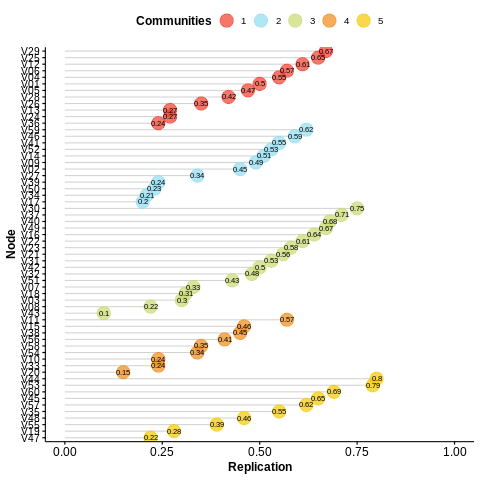

In [39]:
%%R



# Load required library
library(EGAnet)

# Adjust threshold for the correlation matrix
thresholded_matrix <- ifelse(cor_matrix >= 0.25, cor_matrix, 0)

# Perform Bootstrapped EGA using Louvain algorithm
boot_ega_result <- bootEGA(
    data = thresholded_matrix,  # Use the thresholded correlation matrix
    n = nrow(test_items),       # Specify the number of observations (sample size)
    model = "glasso",           # Graphical Lasso for network estimation
    algorithm = "louvain",      # Use Louvain clustering
    iter = 100,                 # Number of bootstrap iterations (adjusted to 500)
    threshold = 0.5             # Adjusted stability threshold
)

# Extract stability results
stable_items <- boot_ega_result$stability$items
cat("Stable Items Identified:\n")
print(stable_items)

# Summary of item stability
item_stability_summary <- boot_ega_result$stability$metrics
print(item_stability_summary)

# Save stability metrics to a CSV
write.csv(item_stability_summary, "bootEGA_stability_metrics_louvain.csv", row.names = FALSE)

# Re-run EGA on stable items using Louvain
if (!is.null(stable_items)) {
    stable_indices <- as.numeric(stable_items)
    stable_cor_matrix <- cor_matrix[stable_indices, stable_indices, drop = FALSE]
    stable_ega_result <- EGA(
        data = stable_cor_matrix,
        model = "glasso",
        algorithm = "louvain",  # Use Louvain clustering
        n = nrow(test_items)
    )

    # Print and visualize final results
    cat("\n--- Stable EGA Results ---\n")
    print(stable_ega_result$wc)
    plot(stable_ega_result, layout = "spring", main = "Stable Louvain Clustering")

    # Save the final clustering results
    stable_clusters <- data.frame(
        item = test_items$item[stable_indices],
        construct = test_items$construct[stable_indices],
        cluster = stable_ega_result$wc
    )
    write.csv(stable_clusters, "final_stable_clusters_louvain.csv", row.names = FALSE)
    cat("\nStable clusters saved to 'final_stable_clusters_louvain.csv'.\n")

    # Save the graph as a PDF
    pdf("Stable_Louvain_Clustering.pdf")
    plot(stable_ega_result, layout = "spring", main = "Stable Louvain Clustering")
    dev.off()
    cat("\nStable Louvain Clustering graph saved as 'Stable_Louvain_Clustering.pdf'.\n")
} else {
    cat("No stable items identified. Please revisit item redundancy or clustering thresholds.")
}


In [21]:
%%R

# Perform Louvain clustering
louvain_result <- cluster_louvain(network)

# Extract community memberships
louvain_communities <- membership(louvain_result)

# Add community labels to items
test_items$louvain_cluster <- louvain_communities

# Summarize clusters
cat("--- Louvain Clustering Summary ---\n")
cat("Number of Communities:", length(unique(louvain_communities)), "\n")
cat("Community Membership Distribution:\n")
print(table(louvain_communities))

# Map items back to constructs
clustered_items <- test_items %>%
  group_by(louvain_cluster) %>%
  summarize(
    items = paste(item, collapse = "; "),
    constructs = paste(unique(construct), collapse = "; "),
    count = n()
  )

# Print clustered items summary
cat("\n--- Clustered Items Summary ---\n")
print(clustered_items)

# Save results to CSV
write.csv(test_items, "louvain_clustered_items.csv", row.names = FALSE)

# Visualize clusters
plot(
  louvain_result,
  network,
  vertex.label = NA,
  vertex.color = as.factor(louvain_communities),
  main = "Louvain Clustering Visualization"
)


--- Louvain Clustering Summary ---
Number of Communities: 3 
Community Membership Distribution:
louvain_communities
 1  2  3 
25 31  4 
Error in `summarize()`:
ℹ In argument: `constructs = paste(unique(construct), collapse = "; ")`.
ℹ In group 1: `louvain_cluster = 1`.
Caused by error:
! object 'construct' not found
Run `rlang::last_trace()` to see where the error occurred.



Error in summarize(., items = paste(item, collapse = "; "), constructs = paste(unique(construct),  : 
  
ℹ In group 1: `louvain_cluster = 1`.
Caused by error:
! object 'construct' not found


In [ ]:
%%R

boot_ega_result <- bootEGA(
    data = thresholded_matrix,
    n = nrow(cor_matrix),
    model = "glasso",
    algorithm = "walktrap",
    iter = 500,
    threshold = 0.75
)

# Extract stable items
stable_items <- boot_ega_result$stability$items
cat("Stable Items Identified:\n")
print(stable_items)


In [17]:
%%R

# Adjust the function to skip plotting for computationally intensive thresholds
adjust_threshold <- function(cor_matrix, thresholds, plot = FALSE) {
    for (threshold in thresholds) {
        # Threshold the correlation matrix
        thresholded_matrix <- cor_matrix
        thresholded_matrix[abs(thresholded_matrix) < threshold] <- 0

        # Calculate sparsity
        zeroed_out <- sum(thresholded_matrix == 0) / (nrow(cor_matrix) * ncol(cor_matrix))
        cat("\n--- Threshold:", threshold, "---\n")
        cat("Proportion of Zeroed-Out Correlations:", zeroed_out, "\n")

        # Perform EGA
        ega_result <- tryCatch(
            EGA(
                data = thresholded_matrix,
                model = "glasso",
                algorithm = "walktrap",
                n = nrow(cor_matrix)
            ),
            error = function(e) {
                cat("EGA failed for threshold:", threshold, "\n")
                return(NULL)
            }
        )

        # Check if EGA succeeded
        if (!is.null(ega_result)) {
            cat("Number of Communities Detected:", length(unique(ega_result$wc)), "\n")
            if (plot) {
                plot(ega_result, layout = "spring")
            }
        }
    }
}


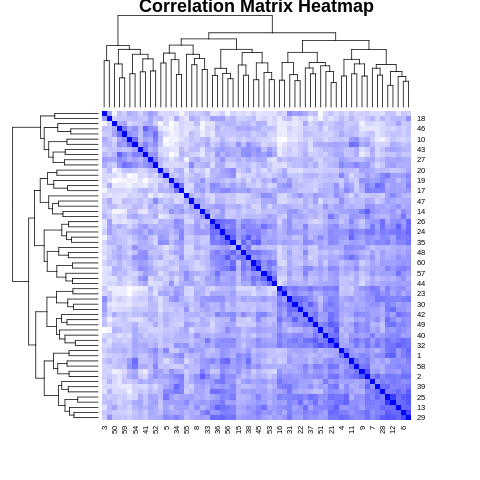

In [18]:
%%R

heatmap(cor_matrix, symm = TRUE, col = colorRampPalette(c("white", "blue"))(100),
        main = "Correlation Matrix Heatmap")


In [31]:
%%R

# Apply UVA for redundancy
library(EGAnet)

# Identify redundant items
uva_result <- UVA(
    data = cor_matrix,
    n = nrow(cor_matrix),
    method = "wTO",  # Weighted Topological Overlap
    threshold = 0.01
)

# Flatten redundant_items into a unique list of redundant labels
all_redundant_items <- unique(unlist(uva_result$redundant))
cat("All Redundant Items Identified:\n")
print(all_redundant_items)



All Redundant Items Identified:
NULL


In [25]:
%%R

# Filter correlation matrix and test items
if (length(all_redundant_items) > 0) {
    valid_indices <- !(rownames(cor_matrix) %in% all_redundant_items)
    filtered_cor_matrix <- cor_matrix[valid_indices, valid_indices, drop = FALSE]
    filtered_items <- test_items[valid_indices, , drop = FALSE]
} else {
    filtered_cor_matrix <- cor_matrix
    filtered_items <- test_items
}

# Validate filtered data
cat("Filtered Items Dimensions:\n")
print(dim(filtered_items))
cat("Filtered Correlation Matrix Dimensions:\n")
print(dim(filtered_cor_matrix))

# Ensure filtered data is not empty
if (nrow(filtered_items) == 0 || ncol(filtered_cor_matrix) == 0) {
    stop("No items remain after filtering. Skipping EGA.")
}

Filtered Items Dimensions:
[1] 60  1
Filtered Correlation Matrix Dimensions:
[1] 60 60


In [19]:
%%R

# Adjust the function to skip plotting for computationally intensive thresholds
adjust_threshold <- function(cor_matrix, thresholds, plot = FALSE) {
    for (threshold in thresholds) {
        # Threshold the correlation matrix
        thresholded_matrix <- cor_matrix
        thresholded_matrix[abs(thresholded_matrix) < threshold] <- 0

        # Calculate sparsity
        zeroed_out <- sum(thresholded_matrix == 0) / (nrow(cor_matrix) * ncol(cor_matrix))
        cat("\n--- Threshold:", threshold, "---\n")
        cat("Proportion of Zeroed-Out Correlations:", zeroed_out, "\n")

        # Perform EGA
        ega_result <- tryCatch(
            EGA(
                data = thresholded_matrix,
                model = "glasso",
                algorithm = "walktrap",
                n = nrow(cor_matrix)
            ),
            error = function(e) {
                cat("EGA failed for threshold:", threshold, "\n")
                return(NULL)
            }
        )

        # Check if EGA succeeded
        if (!is.null(ega_result)) {
            cat("Number of Communities Detected:", length(unique(ega_result$wc)), "\n")
            if (plot) {
                plot(ega_result, layout = "spring")
            }
        }
    }
}


In [ ]:
%%R

# Test with higher thresholds
higher_thresholds <- c(0.35, 0.4, 0.45)
adjust_threshold(cor_matrix, higher_thresholds, plot = FALSE)



--- Threshold: 0.35 ---
Proportion of Zeroed-Out Correlations: 0.2372222 


EGA Communities Detected:
Algorithm:  Walktrap

Number of communities:  8

V01 V02 V03 V04 V05 V06 V07 V08 V09 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 
  1   2   3   1   1   2   2   2   2   4   5   1   2   2   5   6   2   3   2   3 
V21 V22 V23 V24 V25 V26 V27 V28 V29 V30 V31 V32 V33 V34 V35 V36 V37 V38 V39 V40 
  6   6   6   3   1   3   4   2   1   6   6   6   2   2   7   3   6   5   2   6 
V41 V42 V43 V44 V45 V46 V47 V48 V49 V50 V51 V52 V53 V54 V55 V56 V57 V58 V59 V60 
  5   2   5   8   7   4   3   7   6   4   6   4   8   4   8   5   8   2   4   7 
png 
  2 


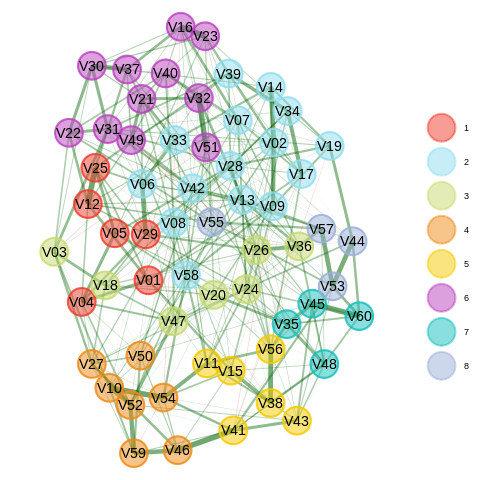

In [24]:
%%R

# Perform EGA
ega_result <- EGA(
    data = filtered_cor_matrix,
    model = "glasso",  # Graphical Lasso
    algorithm = "walktrap",  # Community detection algorithm
    n = nrow(filtered_items)
)

# Print EGA results
cat("EGA Communities Detected:\n")
print(ega_result$wc)

# Plot EGA graph
plot(ega_result, layout = "spring")

# Save EGA graph as PDF
pdf("EGA_graph_filtered.pdf")
plot(ega_result, layout = "spring")
dev.off()


In [34]:
%%R

# Perform Bootstrapped EGA
boot_ega_result <- bootEGA(
    data = filtered_cor_matrix,
    n = nrow(filtered_items),
    model = "glasso",   # Graphical Lasso
    algorithm = "walktrap",  # Community detection algorithm
    iter = 500,   # Number of bootstrap iterations
    threshold = 0.75  # Stability threshold
)

# Extract stable items
stable_items <- boot_ega_result$stability$items
if (is.null(stable_items) || length(stable_items) == 0) {
    stop("No stable items identified. Check BootEGA results.")
}
cat("Stable Items Identified:\n")
print(stable_items)

# Verify alignment before filtering
cat("Filtered Items Dimensions Before Stability Filtering:\n")
print(dim(filtered_items))
cat("Filtered Correlation Matrix Dimensions Before Stability Filtering:\n")
print(dim(filtered_cor_matrix))

# Filter for stable items
final_items <- filtered_items[rownames(filtered_cor_matrix) %in% stable_items, , drop = FALSE]
final_cor_matrix <- filtered_cor_matrix[stable_items, stable_items, drop = FALSE]

# Ensure final data is valid
if (nrow(final_items) < 2 || ncol(final_cor_matrix) < 2) {
    stop("Not enough items remain for final EGA.")
}

# Final EGA on stable items
final_ega_result <- EGA(
    data = final_cor_matrix,
    model = "glasso",
    algorithm = "walktrap",
    n = nrow(final_items)
)

cat("Final EGA Communities Detected:\n")
print(final_ega_result$wc)

# Plot Final EGA graph
plot(final_ega_result, layout = "spring")



Error in withVisible({ : 
  No stable items identified. Check BootEGA results.


In [35]:
%%R

cat("BootEGA Stability Metrics:\n")
print(boot_ega_result$stability)


BootEGA Stability Metrics:
EGA Type: EGA 
Bootstrap Samples: 500 (Parametric)

Proportion Replicated in Dimensions:

  V01   V02   V03   V04   V05   V06   V07   V08   V09   V10   V11   V12   V13 
0.430 0.732 0.108 0.440 0.384 0.276 0.332 0.290 0.634 0.770 0.266 0.484 0.202 
  V14   V15   V16   V17   V18   V19   V20   V21   V22   V23   V24   V25   V26 
0.686 0.292 0.716 0.560 0.242 0.546 0.184 0.694 0.700 0.598 0.236 0.490 0.240 
  V27   V28   V29   V30   V31   V32   V33   V34   V35   V36   V37   V38   V39 
0.726 0.390 0.390 0.786 0.538 0.642 0.366 0.558 0.426 0.240 0.784 0.374 0.476 
  V40   V41   V42   V43   V44   V45   V46   V47   V48   V49   V50   V51   V52 
0.666 0.100 0.100 0.182 0.350 0.514 0.910 0.114 0.428 0.710 0.500 0.542 0.812 
  V53   V54   V55   V56   V57   V58   V59   V60 
0.340 0.690 0.254 0.328 0.350 0.260 0.930 0.502 

----

Structural Consistency:

    1     2     3     4     5     6     7     8 
0.162 0.000 0.006 0.274 0.022 0.148 0.334 0.170 


In [36]:
%%R

summary(cor_matrix[lower.tri(cor_matrix)])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1621  0.3532  0.4233  0.4282  0.4977  0.8027 



Testing Step Size: 2 
Number of Communities Detected: 8 

Testing Step Size: 3 
Number of Communities Detected: 8 

Testing Step Size: 4 
Number of Communities Detected: 8 

Testing Step Size: 5 
Number of Communities Detected: 8 

Testing Step Size: 6 
Number of Communities Detected: 8 


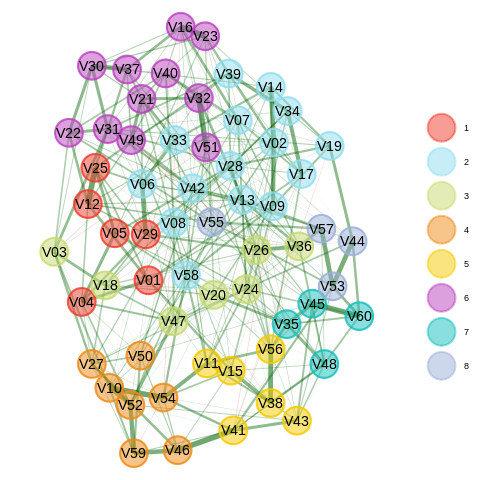

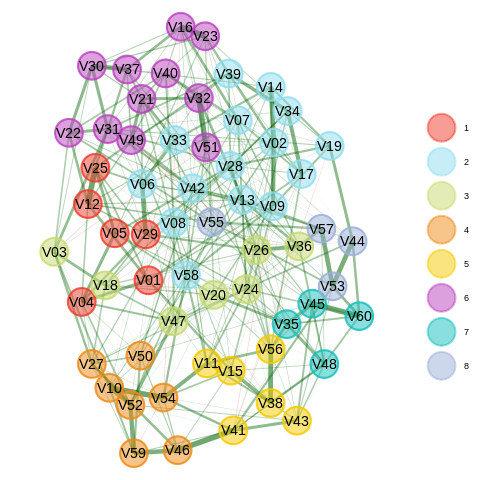

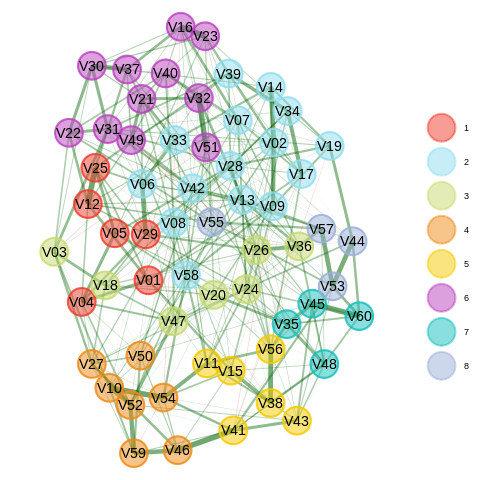

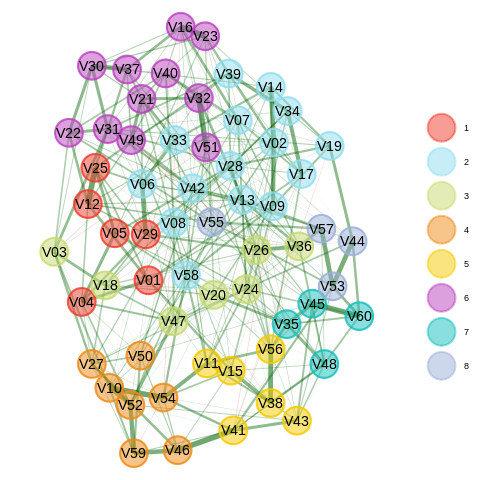

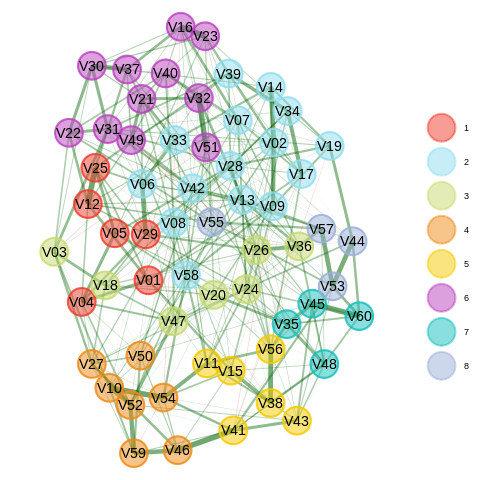

In [38]:
%%R

# Test different step sizes
step_sizes <- 2:6
for (step in step_sizes) {
    cat("\nTesting Step Size:", step, "\n")
    ega_result <- EGA(
        data = filtered_cor_matrix,
        model = "glasso",
        algorithm = "walktrap",
        walktrap_steps = step,
        n = nrow(filtered_items)  # Include the sample size
    )
    cat("Number of Communities Detected:", length(unique(ega_result$wc)), "\n")
}



In [39]:
%%R

# Examine Correlation Matrix Sparsity
cat("\n--- Correlation Matrix Sparsity ---\n")
weak_correlation_proportion <- sum(abs(cor_matrix) < 0.10) / (nrow(cor_matrix)^2)
cat("Proportion of Weak Correlations (< 0.10):", weak_correlation_proportion, "\n")

# Summary Statistics for Correlation Matrix
cat("\n--- Correlation Matrix Summary Statistics ---\n")
cor_values <- cor_matrix[lower.tri(cor_matrix)]
summary_stats <- summary(cor_values)
print(summary_stats)

# Sparsity of Thresholded Correlation Matrix
threshold <- 0.20
cat("\n--- Sparsity of Thresholded Correlation Matrix ---\n")
thresholded_matrix <- cor_matrix
thresholded_matrix[abs(thresholded_matrix) < threshold] <- 0
threshold_sparsity <- sum(thresholded_matrix == 0) / (nrow(thresholded_matrix)^2)
cat("Proportion of Zeroed-Out Correlations After Thresholding:", threshold_sparsity, "\n")

# Eigenvalue Analysis
cat("\n--- Eigenvalue Analysis ---\n")
eigenvalues <- eigen(thresholded_matrix)$values
cat("Eigenvalues of Thresholded Matrix:\n")
print(eigenvalues)

# Node Strength Analysis
cat("\n--- Node Strength Analysis ---\n")
node_strength <- rowSums(abs(thresholded_matrix))
cat("Node Strength Summary:\n")
print(summary(node_strength))



--- Correlation Matrix Sparsity ---
Proportion of Weak Correlations (< 0.10): 0 

--- Correlation Matrix Summary Statistics ---
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1621  0.3532  0.4233  0.4282  0.4977  0.8027 

--- Sparsity of Thresholded Correlation Matrix ---
Proportion of Zeroed-Out Correlations After Thresholding: 0.006666667 

--- Eigenvalue Analysis ---
Eigenvalues of Thresholded Matrix:
 [1] 26.54782352  3.33507162  2.40328625  2.13509764  1.71912551  1.63610413
 [7]  1.41966498  1.27506332  1.18645610  1.05958764  0.98215552  0.90044480
[13]  0.86676365  0.77987923  0.75833928  0.70014114  0.68851366  0.62348511
[19]  0.60385857  0.55903265  0.53993596  0.52163247  0.48169273  0.43396682
[25]  0.42730558  0.41907837  0.39958984  0.39444853  0.37529042  0.35458226
[31]  0.33727383  0.31003100  0.29786500  0.28995928  0.28620880  0.28122922
[37]  0.26077960  0.25886167  0.23668433  0.22653085  0.21432862  0.20706839
[43]  0.20578150  0.19586220  0.18754060  0.182

In [ ]:
%%R

# Function to adjust and evaluate thresholds
adjust_threshold <- function(cor_matrix, thresholds) {
  for (threshold in thresholds) {
    cat("\n--- Threshold:", threshold, "---\n")

    # Apply threshold
    thresholded_matrix <- cor_matrix
    thresholded_matrix[abs(thresholded_matrix) < threshold] <- 0

    # Evaluate sparsity
    zero_proportion <- sum(thresholded_matrix == 0) / (nrow(cor_matrix) * ncol(cor_matrix))
    cat("Proportion of Zeroed-Out Correlations:", zero_proportion, "\n")

    # Run EGA on thresholded matrix
    tryCatch({
      ega_result <- EGA(
        data = thresholded_matrix,
        model = "glasso",
        algorithm = "walktrap",
        n = nrow(cor_matrix)
      )

      cat("Number of Communities Detected:", length(unique(ega_result$wc)), "\n")

      # Optional: Plot the graph
      plot(ega_result, layout = "spring")
    }, error = function(e) {
      cat("EGA failed for threshold", threshold, ":", e$message, "\n")
    })
  }
}

# Define even higher thresholds to test
higher_thresholds <- c(0.35, 0.4, 0.45)

# Call the function with these thresholds
adjust_threshold(cor_matrix, higher_thresholds)




--- Threshold: 0.35 ---
Proportion of Zeroed-Out Correlations: 0.2372222 


In [31]:
%%R

# Step 1: Compute the correlation matrix
cor_matrix <- cor(t(embeddings))
cor_matrix[is.na(cor_matrix)] <- 0  # Replace NAs with 0

print("Correlation Matrix Dimensions:")
print(dim(cor_matrix))

# Step 2: Apply UVA for redundancy
library(EGAnet)
uva_result <- UVA(
    data = cor_matrix,
    n = nrow(test_items),
    method = "wTO",
    threshold = 0.20
)

print("UVA Result:")
print(uva_result)

# Extract redundant items
redundant_items <- uva_result$redundant
if (is.null(redundant_items)) {
    print("No redundant items found. Skipping filtering step.")
    filtered_items <- test_items
    filtered_cor_matrix <- cor_matrix
} else {
    print("Redundant Items Identified:")
    print(redundant_items)

    filtered_items <- test_items[!rownames(cor_matrix) %in% redundant_items, , drop = FALSE]
    filtered_cor_matrix <- cor_matrix[!rownames(cor_matrix) %in% redundant_items,
                                      !colnames(cor_matrix) %in% redundant_items]
}

print("Filtered Items Dimensions:")
print(dim(filtered_items))

print("Filtered Correlation Matrix Dimensions:")
print(dim(filtered_cor_matrix))

# Step 3: Perform EGA
if (all(cor_matrix == 0)) {
    stop("The correlation matrix is empty. Check embeddings or redundant item filtering.")
}

if (nrow(filtered_items) < 3) {
    stop("Not enough items remain after filtering for EGA. Increase item pool or adjust filtering criteria.")
}

ega_result <- EGA(
    data = filtered_cor_matrix,
    model = "glasso",
    algorithm = "walktrap",
    n = nrow(filtered_items)
)

print("EGA Communities Detected:")
print(ega_result$wc)

plot(ega_result, layout = "spring")


[1] "Correlation Matrix Dimensions:"
[1] 6 6
[1] "UVA Result:"
Variable pairs with wTO > 0.30 (large-to-very large redundancy)

----

Variable pairs with wTO > 0.25 (moderate-to-large redundancy)

----

Variable pairs with wTO > 0.20 (small-to-moderate redundancy)
[1] "No redundant items found. Skipping filtering step."
[1] "Filtered Items Dimensions:"
[1] 6 1
[1] "Filtered Correlation Matrix Dimensions:"
[1] 6 6
[1] "EGA Communities Detected:"
Algorithm:  Louvain

Number of communities:  1

V1 V2 V3 V4 V5 V6 
 1  1  1  1  1  1 


NULL
